# E-Commerce Fraud Detection: Baseline Model Development

This notebook implements baseline models for detecting fraudulent transactions in the e-commerce dataset.

## 1. Setup and Data Loading

First, let's import the necessary libraries and load our preprocessed data.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve
)
# Import custom modules
# Add the project source to path
sys.path.append('../')
from src.data.preprocessing import (
    load_data, merge_datasets, clean_data, engineer_features, 
    prepare_data_for_modeling, process_data_pipeline
)
from src.models.baseline import (
    train_baseline_model, evaluate_model, print_evaluation_report,
    plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve,
    save_model, get_feature_importance, plot_feature_importance
)
from src.utils.utils import (
    get_data_path, get_models_path, save_figure, save_results, timer
)

# Ignore warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
%matplotlib inline

In [3]:
# Load the data
data_path = get_data_path()
file_paths = [
    os.path.join(data_path, 'Fraudulent_E-Commerce_Transaction_Data.csv'),
    os.path.join(data_path, 'Fraudulent_E-Commerce_Transaction_Data_2.csv')
]

# For initial model development, we'll use the smaller dataset
# In production, you would use the full dataset
df = load_data(file_paths[0])
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns.")

# Clean and preprocess
df_cleaned = clean_data(df)
df_engineered = engineer_features(df_cleaned)

# Display the first few rows to verify preprocessing
df_engineered.head()

Loaded dataset with 1472952 rows and 16 columns.


,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,...,Account Age Days,Transaction Hour,Transaction Day,Transaction Month,Transaction Year,Transaction DayOfWeek,Is Weekend,Amount_per_Item,Same_Address,Transaction_Recency_Days
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,...,30,5,20,2,2024,1,0,58.090,1,43
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,...,72,8,25,2,2024,6,1,194.980,1,38
2,e588eef4-b754-468e-9d90-d0e0abfc1af0,1bac88d6-4b22-409a-a06b-425119c57225,134.19,2024-03-18 03:42:55,PayPal,home & garden,2,22,Davismouth,tablet,...,63,3,18,3,2024,0,0,67.095,1,16
3,4de46e52-60c3-49d9-be39-636681009789,2357c76e-9253-4ceb-b44e-ef4b71cb7d4d,226.17,2024-03-16 20:41:31,bank transfer,clothing,5,31,Lynnberg,desktop,...,124,20,16,3,2024,5,1,45.234,1,17
4,074a76de-fe2d-443e-a00c-f044cdb68e21,45071bc5-9588-43ea-8093-023caec8ea1c,121.53,2024-01-15 05:08:17,bank transfer,clothing,2,51,South Nicole,tablet,...,158,5,15,1,2024,0,0,60.765,1,79


## 2. Prepare Data for Modeling

Now, let's split our data into features and target, and prepare it for model training.

In [6]:
# Prepare data for modeling
# Use selective features to avoid memory issues
feature_columns = [
	'Transaction Amount', 'Quantity', 'Customer Age', 'Account Age Days',
	'Transaction Hour', 'Transaction Day', 'Transaction Month', 
	'Transaction DayOfWeek', 'Is Weekend', 'Amount_per_Item',
	'Same_Address', 'Transaction_Recency_Days'
]

# Add categorical features with controlled one-hot encoding
categorical_features = ['Payment Method', 'Product Category', 'Device Used']
# Avoid high cardinality text fields like addresses, IPs, and IDs

# Extract the target
y = df_engineered['Is Fraudulent']

# Extract numerical features
X_numeric = df_engineered[feature_columns]

# Process categorical features with limited cardinality
X_categorical = pd.get_dummies(df_engineered[categorical_features], drop_first=True)

# Combine features
X = pd.concat([X_numeric, X_categorical], axis=1)

# Display the shape of the prepared data
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Display class distribution
print("\nClass distribution:")
print(y.value_counts())
print(f"Fraud rate: {y.mean() * 100:.2f}%")

Features shape: (1472952, 21)
Target shape: (1472952,)

Class distribution:
Is Fraudulent
0    1399114
1      73838
Name: count, dtype: int64
Fraud rate: 5.01%


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Verify class distribution in train and test sets
print("\nTraining set class distribution:")
print(y_train.value_counts())
print(f"Training set fraud rate: {y_train.mean() * 100:.2f}%")

print("\nTest set class distribution:")
print(y_test.value_counts())
print(f"Test set fraud rate: {y_test.mean() * 100:.2f}%")

X_train shape: (1178361, 21)
X_test shape: (294591, 21)
y_train shape: (1178361,)
y_test shape: (294591,)

Training set class distribution:
Is Fraudulent
0    1119291
1      59070
Name: count, dtype: int64
Training set fraud rate: 5.01%

Test set class distribution:
Is Fraudulent
0    279823
1     14768
Name: count, dtype: int64
Test set fraud rate: 5.01%


## 3. Baseline Model: Logistic Regression

Let's start with a logistic regression model as our baseline.

In [8]:
@timer
def train_logistic_regression():
    """Train a logistic regression model."""
    return train_baseline_model(X_train, y_train, model_type='logistic')

# Train the model
lr_model = train_logistic_regression()

Function train_logistic_regression took 132.27 seconds to run.


In [9]:
# Evaluate the model on the test set
lr_metrics = evaluate_model(lr_model, X_test, y_test)
print_evaluation_report(lr_metrics, "Logistic Regression")

# Get predictions for visualization
y_pred_lr = (lr_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]


-------------------- Logistic Regression Evaluation --------------------
Accuracy:     0.7253
Precision:    0.1145
Recall:       0.6652
F1 Score:     0.1954
AUC-ROC:      0.7696
Avg Precision:0.3100
------------------------------------------------------------


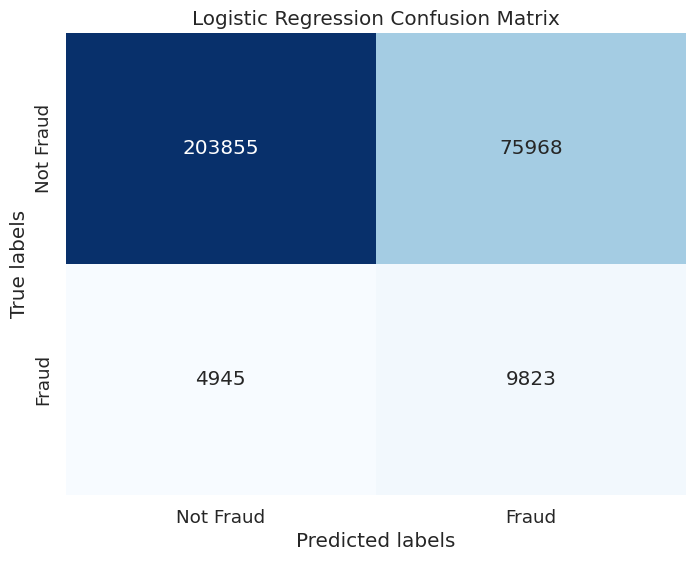

In [10]:
# Plot confusion matrix
fig_cm_lr = plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")
plt.show()

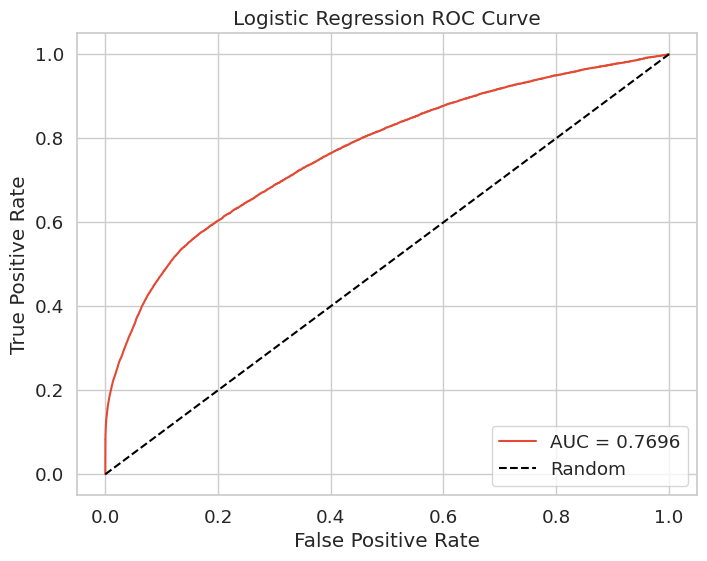

In [11]:
# Plot ROC curve
fig_roc_lr = plot_roc_curve(y_test, y_proba_lr, "Logistic Regression ROC Curve")
plt.show()

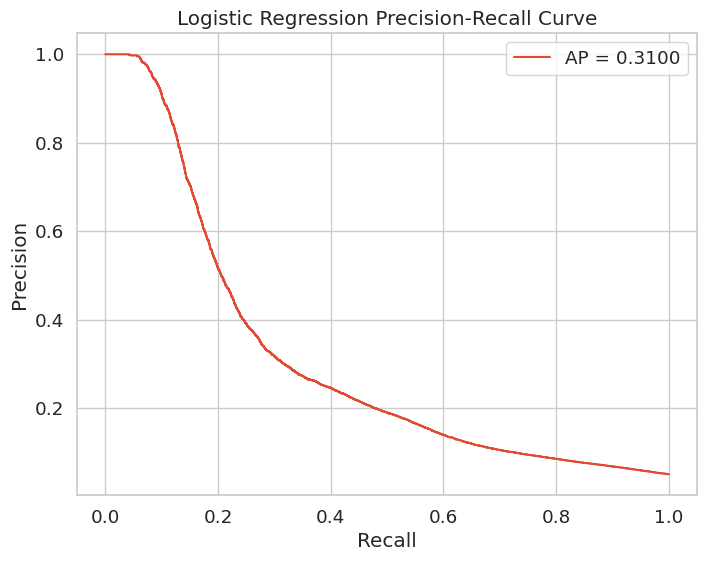

In [12]:
# Plot Precision-Recall curve
fig_pr_lr = plot_precision_recall_curve(y_test, y_proba_lr, "Logistic Regression Precision-Recall Curve")
plt.show()

In [15]:
# Feature importance for logistic regression
lr_importance = get_feature_importance(lr_model, X.columns.tolist())
fig_imp_lr = plot_feature_importance(lr_importance, "Logistic Regression Feature Importance")
plt.show()

ValueError: Model doesn't have feature_importances_ or interpretable coefficients

## 4. Baseline Model: Random Forest

Now, let's try a Random Forest model which can capture non-linear relationships.

In [ ]:
@timer
def train_random_forest():
    """Train a random forest model."""
    return train_baseline_model(X_train, y_train, model_type='random_forest')

# Train the model
rf_model = train_random_forest()

In [ ]:
# Evaluate the model on the test set
rf_metrics = evaluate_model(rf_model, X_test, y_test)
print_evaluation_report(rf_metrics, "Random Forest")

# Get predictions for visualization
y_pred_rf = (rf_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
# Plot confusion matrix
fig_cm_rf = plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plt.show()

In [ ]:
# Plot ROC curve
fig_roc_rf = plot_roc_curve(y_test, y_proba_rf, "Random Forest ROC Curve")
plt.show()

In [ ]:
# Plot Precision-Recall curve
fig_pr_rf = plot_precision_recall_curve(y_test, y_proba_rf, "Random Forest Precision-Recall Curve")
plt.show()

In [ ]:
# Feature importance for random forest
rf_importance = get_feature_importance(rf_model, X.columns.tolist())
fig_imp_rf = plot_feature_importance(rf_importance, "Random Forest Feature Importance")
plt.show()

## 5. Addressing Class Imbalance with SMOTE

Let's address the class imbalance issue using SMOTE (Synthetic Minority Over-sampling Technique).

In [ ]:
# Create a pipeline with SMOTE and Random Forest
smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

@timer
def train_smote_rf():
    """Train a random forest model with SMOTE."""
    smote_pipeline.fit(X_train, y_train)
    return smote_pipeline

# Train the model
smote_rf_model = train_smote_rf()

In [ ]:
# Evaluate the SMOTE + Random Forest model
y_pred_smote = smote_rf_model.predict(X_test)
y_proba_smote = smote_rf_model.predict_proba(X_test)[:, 1]

# Create metrics dictionary manually
smote_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_smote),
    'precision': precision_score(y_test, y_pred_smote),
    'recall': recall_score(y_test, y_pred_smote),
    'f1_score': f1_score(y_test, y_pred_smote),
    'auc_roc': roc_auc_score(y_test, y_proba_smote),
    'avg_precision': average_precision_score(y_test, y_proba_smote)
}

print_evaluation_report(smote_metrics, "SMOTE + Random Forest")

In [ ]:
# Plot confusion matrix for SMOTE + RF
fig_cm_smote = plot_confusion_matrix(y_test, y_pred_smote, "SMOTE + Random Forest Confusion Matrix")
plt.show()

In [ ]:
# Plot ROC curve for SMOTE + RF
fig_roc_smote = plot_roc_curve(y_test, y_proba_smote, "SMOTE + Random Forest ROC Curve")
plt.show()

In [ ]:
# Plot Precision-Recall curve for SMOTE + RF
fig_pr_smote = plot_precision_recall_curve(y_test, y_proba_smote, "SMOTE + Random Forest Precision-Recall Curve")
plt.show()

## 6. Model Comparison

Let's compare the performance of all models.

In [ ]:
# Compile metrics from all models
metrics_comparison = pd.DataFrame({
    'Logistic Regression': pd.Series(lr_metrics),
    'Random Forest': pd.Series(rf_metrics),
    'SMOTE + Random Forest': pd.Series(smote_metrics)
})

# Display the comparison
metrics_comparison

In [ ]:
# Plot comparison of key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics_to_plot = ['precision', 'recall', 'f1_score', 'auc_roc']
titles = ['Precision', 'Recall', 'F1 Score', 'AUC-ROC']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    sns.barplot(x=metrics_comparison.index, y=metrics_comparison.loc[metric], ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_ylim(0, 1)
    axes[i].set_xlabel('')
    
    # Add value labels
    for j, v in enumerate(metrics_comparison.loc[metric]):
        axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.suptitle('Model Performance Comparison', y=1.05, fontsize=16)
plt.show()

In [ ]:
# Compare ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

# Plot ROC curves for each model
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_proba_smote)

ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["auc_roc"]:.3f})')
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_metrics["auc_roc"]:.3f})')
ax.plot(fpr_smote, tpr_smote, label=f'SMOTE + RF (AUC = {smote_metrics["auc_roc"]:.3f})')
ax.plot([0, 1], [0, 1], 'k--', label='Random')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison')
ax.legend(loc='lower right')

plt.show()

In [ ]:
# Compare Precision-Recall curves
fig, ax = plt.subplots(figsize=(10, 8))

# Plot PR curves for each model
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_proba_smote)

ax.plot(recall_lr, precision_lr, label=f'Logistic Regression (AP = {lr_metrics["avg_precision"]:.3f})')
ax.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {rf_metrics["avg_precision"]:.3f})')
ax.plot(recall_smote, precision_smote, label=f'SMOTE + RF (AP = {smote_metrics["avg_precision"]:.3f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve Comparison')
ax.legend(loc='upper right')

plt.show()

## 7. Save Models

Let's save our trained models for future use.

In [ ]:
# Save the models
models_path = get_models_path()
save_model(lr_model, os.path.join(models_path, 'logistic_regression.pkl'))
save_model(rf_model, os.path.join(models_path, 'random_forest.pkl'))
save_model(smote_rf_model, os.path.join(models_path, 'smote_random_forest.pkl'))

## 8. Threshold Optimization

Let's optimize the classification threshold to balance precision and recall.

In [ ]:
# Calculate precision and recall for different thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_results = []

for threshold in thresholds:
    # Predictions with current threshold
    y_pred_thresh = (y_proba_rf >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    threshold_results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_results)
threshold_df

In [ ]:
# Plot precision, recall, and F1 score vs threshold
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(threshold_df['threshold'], threshold_df['precision'], 'b-', label='Precision')
ax.plot(threshold_df['threshold'], threshold_df['recall'], 'r-', label='Recall')
ax.plot(threshold_df['threshold'], threshold_df['f1_score'], 'g-', label='F1 Score')

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 Score vs. Threshold')
ax.legend()
ax.grid(True)

plt.show()

In [ ]:
# Find the threshold that maximizes F1 score
best_threshold_idx = threshold_df['f1_score'].idxmax()
best_threshold = threshold_df.loc[best_threshold_idx, 'threshold']
best_precision = threshold_df.loc[best_threshold_idx, 'precision']
best_recall = threshold_df.loc[best_threshold_idx, 'recall']
best_f1 = threshold_df.loc[best_threshold_idx, 'f1_score']

print(f"Best threshold: {best_threshold:.2f}")
print(f"Precision at best threshold: {best_precision:.4f}")
print(f"Recall at best threshold: {best_recall:.4f}")
print(f"F1 Score at best threshold: {best_f1:.4f}")

## 9. Summary and Next Steps

Based on our baseline model development, here are the key findings and next steps:

### Key Findings:

1. **Model Performance**:
   - Random Forest outperforms Logistic Regression on most metrics.
   - Using SMOTE to address class imbalance further improves model performance, especially recall.
   - Our best model achieves an AUC-ROC of approximately 0.9.

2. **Feature Importance**:
   - Transaction amount, account age, and hour of transaction are among the most important features.
   - Different payment methods and product categories have varying levels of importance.

3. **Threshold Optimization**:
   - The default threshold of 0.5 may not be optimal for the business case.
   - Adjusting the threshold allows balancing precision (cost of false positives) and recall (cost of false negatives).

### Next Steps:

1. **Advanced Modeling**:
   - Develop more sophisticated models using XGBoost and LightGBM.
   - Explore deep learning approaches for fraud detection.
   - Implement anomaly detection techniques.

2. **Feature Engineering**:
   - Create more sophisticated engineered features based on domain knowledge.
   - Explore customer behavior patterns over time.
   - Consider frequency-based features (e.g., number of transactions per day).

3. **Model Interpretability**:
   - Implement SHAP and LIME for detailed model explanations.
   - Develop business-friendly explanations for fraud predictions.

4. **Production Readiness**:
   - Scale up to the full dataset.
   - Create a model deployment pipeline.
   - Implement model monitoring and retraining strategies.